# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [26]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [27]:
env = gym.make('Blackjack-v1')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [28]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [29]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(16, 9, False)
(20, 9, False)
End game! Reward:  1.0
You won :)

(9, 10, False)
(16, 10, False)
End game! Reward:  1.0
You won :)

(12, 7, True)
(19, 7, True)
(12, 7, False)
End game! Reward:  -1.0
You lost :(



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [30]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [31]:
for i in range(10):
    print(generate_episode_from_limit_stochastic(env))

[((21, 4, True), 0, 1.0)]
[((12, 10, False), 1, -1.0)]
[((14, 10, False), 1, -1.0)]
[((6, 3, False), 1, 0.0), ((16, 3, False), 0, 1.0)]
[((4, 1, False), 0, -1.0)]
[((18, 1, False), 1, -1.0)]
[((20, 10, False), 0, 0.0)]
[((8, 10, False), 1, 0.0), ((18, 10, False), 1, -1.0)]
[((12, 2, False), 1, 0.0), ((13, 2, False), 0, -1.0)]
[((12, 10, False), 0, -1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [32]:
# This method will return the reward of the first timestep, plus the discounted rewards of any future timesteps.
def discounted_rewards_in_episode(episode, gamma=1.0):
    # Accumulate rewards at this state/action pair by adding the reward in this frame, 
    # plus the discounted sum of rewards for future frames.

    rewards_from_state = 0.0
    for t, state_action_reward in enumerate(episode):
        t_reward = state_action_reward[2]

        if t == 0:
            # Append the reward if this is the first element.
            rewards_from_state += t_reward
        else:
            # Else append the discounted reward.
            rewards_from_state += gamma * t_reward
    
    #print("rewards_from_state: ", rewards_from_state)
    return rewards_from_state

In [33]:
# Test the code above
def test_discounted_rewards_in_episode():
    episode = [((13, 4, False), 1, 0.0), ((16, 4, False), 1, 0.0), ((17, 4, False), 1, 0.0), ((21, 4, False), 0, 1.0)]

    for i in range(4):
        sliced_episode = episode[i:]
        discounted_rewards = discounted_rewards_in_episode(sliced_episode)
        print("sliced_episode: ", sliced_episode)
        print("discounted_rewards: ", discounted_rewards)
        
test_discounted_rewards_in_episode()

sliced_episode:  [((13, 4, False), 1, 0.0), ((16, 4, False), 1, 0.0), ((17, 4, False), 1, 0.0), ((21, 4, False), 0, 1.0)]
discounted_rewards:  1.0
sliced_episode:  [((16, 4, False), 1, 0.0), ((17, 4, False), 1, 0.0), ((21, 4, False), 0, 1.0)]
discounted_rewards:  1.0
sliced_episode:  [((17, 4, False), 1, 0.0), ((21, 4, False), 0, 1.0)]
discounted_rewards:  1.0
sliced_episode:  [((21, 4, False), 0, 1.0)]
discounted_rewards:  1.0


In [34]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        # Generate an episode
        episode = generate_episode(env)
        #print("episode: ", episode)
        
        # Iterate over each timestep
        for t, stateActionReward in enumerate(episode):
            # Each timestep contains state, action, reward
            state = stateActionReward[0]
            action = stateActionReward[1]
            reward = stateActionReward[2]
            #print("state: ", state)
            #print("action: ", action)
            #print("reward: ", reward)
            
            # Accumulate rewards at this state/action pair by adding the reward in this frame, 
            # plus the discounted sum of rewards for future frames.
            rewards_from_state = discounted_rewards_in_episode(episode[t:], gamma)
            
            # Add to total rewards at state/action
            returns_sum[state][action] += rewards_from_state
            
            # Increment total visits at state/action
            N[state][action] += 1.0
            
            # Assign Q value (average reward for state/action)
            Q[state][action] = returns_sum[state][action] / N[state][action]
        
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

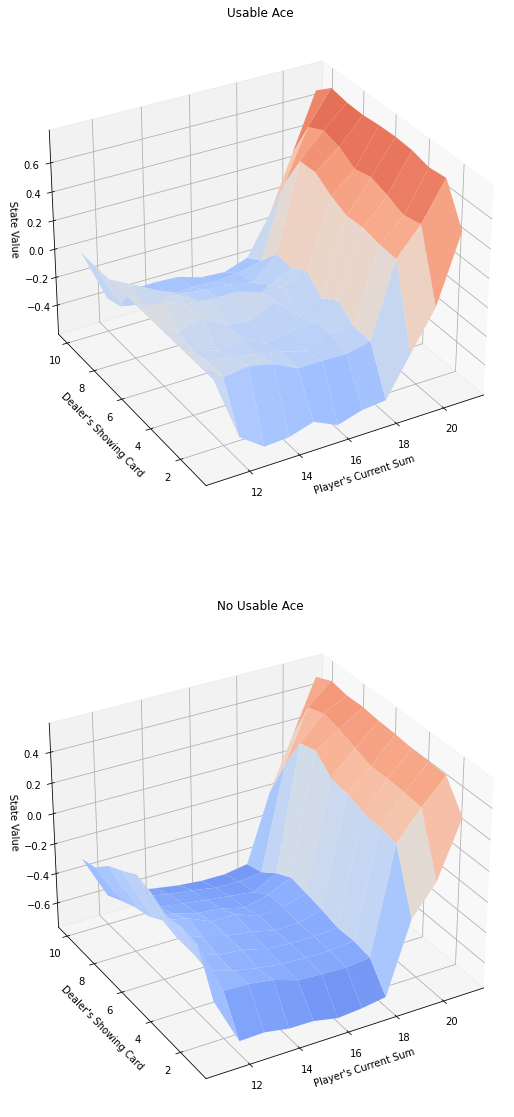

In [35]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)
#Q = mc_prediction_q(env, 5, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [36]:
def decay_epsilon(eps_current, eps_decay, eps_min):
    eps_decayed = eps_current * eps_decay
    return eps_decayed if eps_decayed > eps_min else eps_min

In [38]:
def test_decay_epsilon():
    for eps_decay in [1, 0.5, 0.3, 0.1, 0.01]:
        eps_decayed = decay_epsilon(1.0, eps_decay, 0.1)
        print("eps_decayed(1.0, {eps_decay}, 0.1): {eps_decayed}".format(**locals()))

test_decay_epsilon()

eps_decayed(1.0, 1, 0.1): 1.0
eps_decayed(1.0, 0.5, 0.1): 0.5
eps_decayed(1.0, 0.3, 0.1): 0.3
eps_decayed(1.0, 0.1, 0.1): 0.1
eps_decayed(1.0, 0.01, 0.1): 0.1


In [66]:
def get_action_with_highest_reward(actions):
    # Initialize best_action and reward to the first index.
    best_action = 0
    reward = actions[0]
    for i in range(len(actions)):
        if actions[i] > reward:
            reward = actions[i]
            best_action = i
    return best_action

In [68]:
def test_get_action_with_highest_reward():
    stateActionDict = { 3: [-0.9, -1.0], 6: [-0.4, -0.2], 12: [1, 10], 16: [3, 8], 20: [10, 1]  }
    for i, key in enumerate(stateActionDict):
        best_action = get_action_with_highest_reward(stateActionDict[key])
        print("key: ", key, ", best action: ", best_action)

test_get_action_with_highest_reward()

key:  3 , best action:  0
key:  6 , best action:  1
key:  12 , best action:  1
key:  16 , best action:  1
key:  20 , best action:  0


In [41]:
def get_probabilities_epsilon_greedy(epsilon):
    # 1 - epsilon = action with highest rewards for the state
    # epsilon = random action
    # probability for random action will be 1 / numPossibleActions (which is 2 for blackjack -- stay and hold)
    
    # Return an array of 3 elements, in terms of probability of choosing the following actions:
    #   1. best current action
    #   2. stick (0)
    #   3. hit (1)
    return [1.0 - epsilon, epsilon / 2, epsilon / 2]

In [42]:
def test_get_probabilities_epsilon_greedy():
    for epsilon in [1.0, 0.7, 0.3, 0.1]:
        print("epsilon: ", epsilon, ", probs: ", get_probabilities_epsilon_greedy(epsilon))

test_get_probabilities_epsilon_greedy()

epsilon:  1.0 , probs:  [0.0, 0.5, 0.5]
epsilon:  0.7 , probs:  [0.30000000000000004, 0.35, 0.35]
epsilon:  0.3 , probs:  [0.7, 0.15, 0.15]
epsilon:  0.1 , probs:  [0.9, 0.05, 0.05]


In [43]:
def choose_action_epsilon_greedy(Q, state, epsilon):
    probs = get_probabilities_epsilon_greedy(epsilon)

    # Get current best action for the state
    best_action = get_action_with_highest_reward(Q[state])

    # Choose an action, based on epsilon probability
    action = np.random.choice(np.array([best_action, 0, 1]), p=probs)
    
    return action

In [50]:
def test_choose_action_epsilon_greedy(epsilon):
    # Run a particular state a few times, with differing epsilons, to be satisfied that it's choosing
    # the best action for a particular state, with respect to epsilon.
    state = 12
    state_action_dict = { state: [2, 10] }
    action = choose_action_epsilon_greedy(state_action_dict, state, epsilon)
    print("Action: ", action)

# Test 10 times with epsilon 1.0. Should be very random between 0 and 1. Around 50/50, but random.
print("Testing choose_action_epsilon_greedy with epsilon 1.0")
for i in range(10):
    test_choose_action_epsilon_greedy(1.0)

# Test 10 times with epsilon 0.5. Should be HIT (1) approximatly 75% of the time.
print("Testing choose_action_epsilon_greedy with epsilon 0.5")
for i in range(10):
    test_choose_action_epsilon_greedy(0.5)

# Test 10 times with epsilon 0.1. Should be HIT (1) approximatly 90% of the time.
print("Testing choose_action_epsilon_greedy with epsilon 0.1")
for i in range(10):
    test_choose_action_epsilon_greedy(0.1)
    
# Test 10 times with epsilon 0.0. Should be HIT (1) 100% of the time.
print("Testing choose_action_epsilon_greedy with epsilon 0.0")
for i in range(10):
    test_choose_action_epsilon_greedy(0.0)

Testing choose_action_epsilon_greedy with epsilon 1.0
Action:  0
Action:  1
Action:  1
Action:  1
Action:  0
Action:  1
Action:  1
Action:  0
Action:  0
Action:  1
Testing choose_action_epsilon_greedy with epsilon 0.5
Action:  1
Action:  1
Action:  1
Action:  0
Action:  0
Action:  0
Action:  0
Action:  1
Action:  0
Action:  1
Testing choose_action_epsilon_greedy with epsilon 0.1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  0
Action:  1
Testing choose_action_epsilon_greedy with epsilon 0.0
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1
Action:  1


In [51]:
def generate_episode_epsilon_greedy(env, epsilon, Q):
    episode = []
    state = env.reset()
    while True:
        action = choose_action_epsilon_greedy(Q, state, epsilon)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [52]:
def get_policy_from_Q_table(Q):
    policy = {}
    for i, state in enumerate(Q):
        best_action = get_action_with_highest_reward(Q[state])
        policy[state] = best_action
    
    return policy

In [53]:
def test_get_policy_from_Q_table():
    mydict = { 12: [2, 8], 15: [4, 6], 19: [9, 1], 21: [10, 0] }
    policy = get_policy_from_Q_table(mydict)
    print("policy: ", policy)
    
test_get_policy_from_Q_table();

policy:  {12: 1, 15: 1, 19: 0, 21: 0}


In [69]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    # For debugging purposes
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Initialize epsilon
    epsilon = eps_start
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        # Decay epsilon
        if i_episode > 1:
            epsilon = decay_epsilon(epsilon, eps_decay, eps_min)
        #print("epsilon: ", epsilon)
        
        # Generate an episode
        episode = generate_episode_epsilon_greedy(env, epsilon, Q)
        #print("episode: ", episode)

        # Iterate over each timestep
        for t, stateActionReward in enumerate(episode):
            #print("t: ", t)
            # Each timestep contains state, action, reward
            state = stateActionReward[0]
            action = stateActionReward[1]
            reward = stateActionReward[2]
            #print("state: ", state)
            #print("action: ", action)
            #print("reward: ", reward)
            
            # What is our current stored Q value for this particular state and action?
            q_stateaction = Q[state][action]
            #print("q_stateaction: ", q_stateaction)
            #if N[state][action] > 0:
            #    print("Episode contains a state to update: ", episode)
            #    print("Updating state: ", state, ", action: ", action, ", existing_q_value: ", q_stateaction, ", reward: ", reward)

            # Get discounted total rewards in episode from this timestep forward.
            rewards_from_state = discounted_rewards_in_episode(episode[t:], gamma)
            #print("rewards_from_state: ", rewards_from_state)

            # Update our Q Table for this particular state and action.
            new_q_value = q_stateaction + alpha * (rewards_from_state - q_stateaction)
            #print("new_q_value: ", new_q_value)
            #if N[state][action] > 0:
            #    print("Updating state: ", state, ", action: ", action, ", rewards_from_state: ", rewards_from_state, " with new_q_value: ", new_q_value)
            
            # Update Q value
            Q[state][action] = new_q_value
            #print("Q[", state, "][", action, "]: ", Q[state][action])
            #if N[state][action] > 0:
            #    print("New Q Value for state: ", state, ", action: ", action, ": ", Q[state][action])
            #    print("\n")
                
            # Update N for state action, for debugging.
            N[state][action] += 1
            
    policy = get_policy_from_Q_table(Q)
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [81]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.01)

# Debugging implementation by printing out our dictionaries.
print("Final Q Table:")
for i, state in enumerate(Q):
    print("State: ", state, "; STICK: ", Q[state][0], ", HIT: ", Q[state][1])

print("\n\nFinal Policy:")
for i, state in enumerate(policy):
    print("State: ", state, ": Action: ", "STICK" if policy[state] == 0 else "HIT")


Episode 500000/500000.Final Q Table:
State:  (14, 10, False) ; STICK:  -0.6690393203477828 , HIT:  -0.47116921589689553
State:  (15, 10, False) ; STICK:  -0.7080916316244705 , HIT:  -0.5542437098070512
State:  (12, 10, False) ; STICK:  -0.497238134475551 , HIT:  -0.47342582430350133
State:  (12, 1, False) ; STICK:  -0.7595688561558781 , HIT:  -0.4310906961720102
State:  (10, 6, False) ; STICK:  -0.12127838198307941 , HIT:  0.22647016801870837
State:  (16, 10, True) ; STICK:  -0.5864769811644801 , HIT:  -0.278472556872247
State:  (12, 10, True) ; STICK:  -0.31458808989477816 , HIT:  -0.24025766007450391
State:  (21, 10, True) ; STICK:  0.9523933698105074 , HIT:  -0.030620537116798203
State:  (19, 2, False) ; STICK:  0.3689032683144463 , HIT:  -0.7084779081842559
State:  (11, 3, False) ; STICK:  -0.26388940560216667 , HIT:  0.28323113372322634
State:  (13, 3, False) ; STICK:  -0.40482872834101585 , HIT:  -0.3923751917428821
State:  (12, 9, False) ; STICK:  -0.5557608953879702 , HIT:  -0.

State:  (20, 5, True) ; STICK:  0.7414430367706223 , HIT:  0.03235340289915336
State:  (20, 4, True) ; STICK:  0.6489156672786757 , HIT:  0.037588693488706165
State:  (14, 8, True) ; STICK:  -0.283116424684132 , HIT:  -0.02623627159659052
State:  (12, 3, True) ; STICK:  -0.08253605437443721 , HIT:  0.11740927037609081
State:  (16, 9, True) ; STICK:  -0.2869238570067356 , HIT:  -0.15319627838617614
State:  (20, 8, True) ; STICK:  0.8163154437368298 , HIT:  -0.0495580038482123
State:  (6, 3, False) ; STICK:  -0.27411166254282754 , HIT:  -0.155248291151458
State:  (6, 2, False) ; STICK:  -0.22252157849039117 , HIT:  -0.19240213380701132
State:  (20, 3, True) ; STICK:  0.679367946080728 , HIT:  -0.025029613856500783
State:  (13, 2, True) ; STICK:  -0.1743741943986497 , HIT:  0.046845343503458745
State:  (4, 7, False) ; STICK:  -0.2591987051963572 , HIT:  -0.20159130714108658
State:  (16, 3, True) ; STICK:  -0.18257134995094726 , HIT:  -0.09255650343348579
State:  (17, 8, True) ; STICK:  -0

Next, we plot the corresponding state-value function.

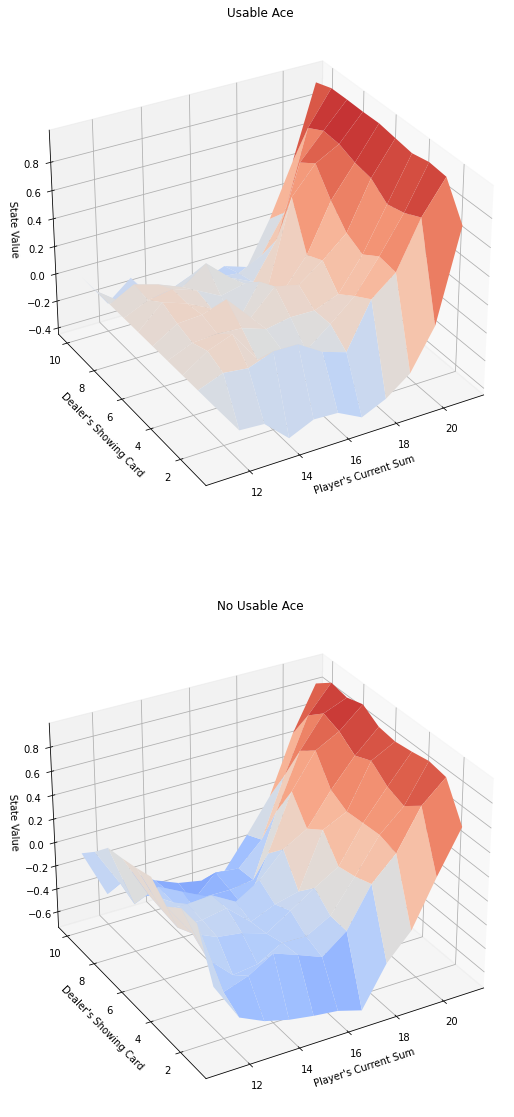

In [82]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

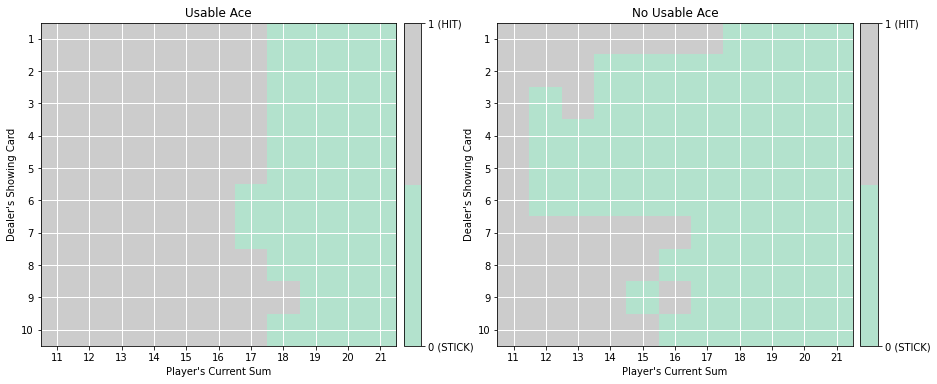

In [83]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)